In [1]:
using PyPlot
using Random
using LinearAlgebra
using Statistics
using Test

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1317


In [318]:
include("power_functions.jl")
include("jacobi_functions.jl")
include("qr_functions.jl")

QRwithoutShifts (generic function with 1 method)

In [112]:
A = [1.0 5 6;
    5 23 9;
    6 9 18]

3×3 Matrix{Float64}:
 1.0   5.0   6.0
 5.0  23.0   9.0
 6.0   9.0  18.0

In [105]:
n = 40;
A = randn(n,n); A = A'*A;

In [113]:
Λ, V = jacobi_B(A, 3000);
Λ_in, V_in = eigen(A);
@test Λ ≈ Λ_in

Test Passed

In [114]:
Λ

3-element Vector{Float64}:
 -1.1208524883328226
 11.385955003872924
 31.734897484459903

In [115]:
V

3×3 Matrix{Float64}:
  0.961908  -0.128222  0.241438
 -0.105256   0.641379  0.759969
 -0.252298  -0.756434  0.603452

In [116]:
Λ_in

3-element Vector{Float64}:
 -1.1208524883328082
 11.385955003872954
 31.734897484459903

In [117]:
V_in

3×3 Matrix{Float64}:
  0.961908   0.128222  -0.241438
 -0.105256  -0.641379  -0.759969
 -0.252298   0.756434  -0.603452

### Przygotowanie danych

In [118]:
function make_moon(; n_samples = 100, shuffle = true)
    n_samples_out = n_samples ÷ 2
    n_samples_in = n_samples - n_samples_out

    X = zeros(2,n_samples)
    y = zeros(n_samples)

    # outer circle
    X[1,1:n_samples_out] = cos.(LinRange(0, π, n_samples_out))
    X[2,1:n_samples_out] = sin.(LinRange(0, π, n_samples_out))
    y[1:n_samples_out] .= 0

    # inner circle
    X[1,n_samples_out+1:end] = 1 .- cos.(LinRange(0, π, n_samples_in))
    X[2,n_samples_out+1:end] = 1 .- sin.(LinRange(0, π, n_samples_in)) .- 0.5
    y[n_samples_out+1:end] .= 1

    if shuffle
       ind = randperm(n_samples)
       return X[:,ind],y[ind]
    else
       return X,y
    end
end

N = 100
X,y = make_moon(n_samples = N)

([-0.9815591569910654 -0.4625382902408351 … -0.9979453927503363 1.9815591569910653; 0.1911586287013721 0.8865993063730001 … 0.06407021998071323 0.3088413712986279], [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0  …  1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0])

In [45]:
Λ_in

3-element Vector{Float64}:
 -1.1208524883328082
 11.385955003872954
 31.734897484459903

In [44]:
V_in

3×3 Matrix{Float64}:
  0.961908   0.128222  -0.241438
 -0.105256  -0.641379  -0.759969
 -0.252298   0.756434  -0.603452

In [119]:
PyPlot.plt.rc("image", cmap = "RdYlBu_r")

In [951]:
V

50×50 Matrix{Float64}:
 -0.087689    -0.13131      0.123024    …   0.0607609    0.0189177
 -0.0450316    0.0756184   -0.0596119      -0.178174    -0.136793
  0.0356539   -0.119256     0.278394       -0.0697855   -0.0696676
  0.00881744  -0.116691    -0.058622        0.0269897    0.361392
  0.00274265  -0.172652    -0.30944         0.120326     0.00400852
  0.223002     0.034967    -0.0279179   …   0.174082    -0.0726234
  0.209515     0.161201    -0.0166696      -0.0902532    0.0936733
  0.0174298    0.00658951   0.260508       -0.0100169   -0.0198326
  0.179883    -0.060088     0.107552        0.202892    -0.161891
 -0.103096     0.0309992   -0.0058894       0.13148     -0.101477
 -0.274087    -0.154615    -0.157226    …  -0.0371943    0.151781
 -0.0481905    0.21665     -0.400055       -0.168532    -0.206568
 -0.287437    -0.0310909    0.103955       -0.0677455    0.0126911
  ⋮                                     ⋱               
  0.267749    -0.123238    -0.0609239      -0.0680323 

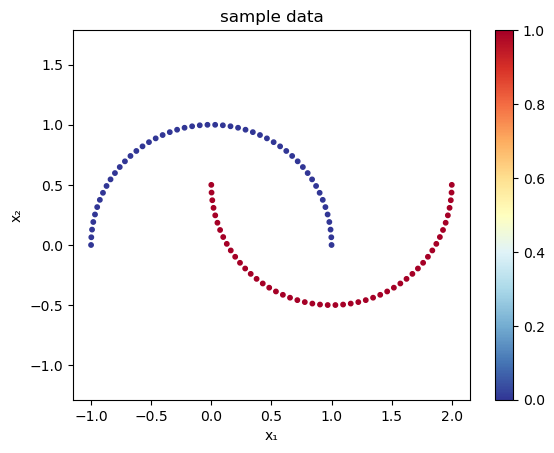

In [120]:
title("sample data")
scatter(X[1,:],X[2,:],10,y); colorbar();
xlabel("x₁")
ylabel("x₂")
axis("equal");

### Metoda SVD na podstawie algorytmu Grama-Schmidta

In [121]:
function my_svd(A::Matrix; maxiter=1000)
    V = randn(size(A,2), size(A,1)) # random initialization
    for _ = 1:maxiter
        W = A * V
        Z = A' * W
        V, R = mgramschmidt(Z)
    end
    W = A * V
    S = [norm(W[:, i]) for i=1:size(W,2)] # singular values
    U = reduce(hcat,[W[:,i]/S[i] for i=1:size(W,2)]) # left singular vectors
    return U, S, V
end

my_svd (generic function with 1 method)

In [122]:
Xa = X .- mean(X,dims=2);
U,Σ,V = my_svd(Xa);

@test Xa ≈ U * Diagonal(Σ) * V'

Test Passed

### Klasyczna metoda PCA na podstawie własnego algorytmu wyznaczania wartości własnych

In [426]:
function my_pca(A::Matrix; maxiter=1000)
    C = A .- mean(A);
    Λ, V = jacobi_B(cov(C'), maxiter);
    W = V;
    P = W * A;
#     reverse(P, dims=1)
end

my_pca (generic function with 2 methods)

PCA - Dane Iris

In [412]:
using RDatasets
iris = dataset("datasets", "iris");

In [413]:
Xtr = convert(Array,(iris[1:2:end,1:4]));
Xtr_labels = convert(Array,(iris[1:2:end,5]));
Xtr = hcat(Xtr');

In [427]:
X_pca = my_pca(Xtr, 2, maxiter=250)

4×75 Matrix{Float64}:
  5.65611    5.20389   5.63279    5.26031   …   7.19414   6.31614   6.82248
 -2.30237   -2.11161  -2.24804   -1.98242      -1.84891  -2.10107  -1.72232
  1.5442     1.41032   1.64585    1.63323       3.37853   2.58508   3.44395
  0.763505   0.72914   0.684942   0.708292      5.28502   4.85379   4.80381

In [457]:
setosa = Xtr[:,Xtr_labels.=="setosa"];
versicolor = Xtr[:,Xtr_labels.=="versicolor"];
virginica = Xtr[:,Xtr_labels.=="virginica"];

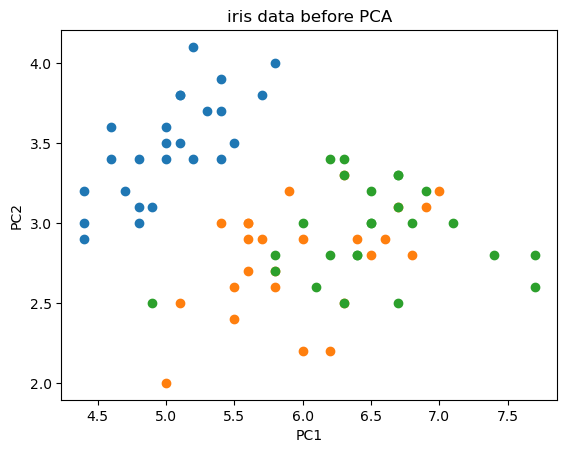

PyObject Text(24.000000000000007, 0.5, 'PC2')

In [458]:
title("iris data before PCA")
scatter(setosa[1,:],setosa[2,:])
scatter(versicolor[1,:],versicolor[2,:])
scatter(virginica[1,:],virginica[2,:])
xlabel("PC1")
ylabel("PC2")

In [459]:
X_pca = my_pca(Xtr, maxiter=100)
setosa = X_pca[:,Xtr_labels.=="setosa"];
versicolor = X_pca[:,Xtr_labels.=="versicolor"];
virginica = X_pca[:,Xtr_labels.=="virginica"];

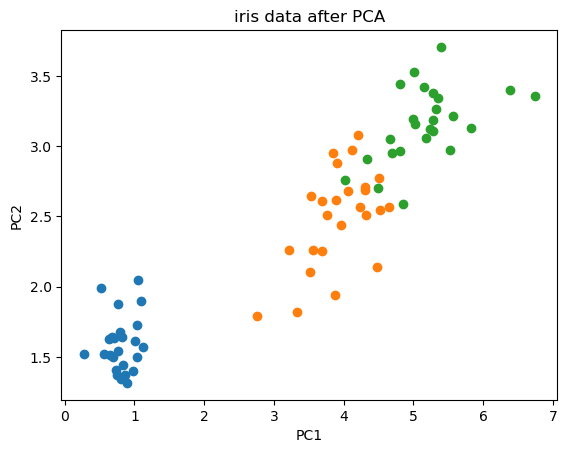

PyObject Text(24.000000000000007, 0.5, 'PC2')

In [460]:
title("iris data after PCA")
scatter(setosa[1,:],setosa[2,:])
scatter(versicolor[1,:],versicolor[2,:])
scatter(virginica[1,:],virginica[2,:])
xlabel("PC1")
ylabel("PC2")

### Metoda PCA wykorzystująca jądro RBF na podstawie własnego algorytmu wyznaczania wartości własnych

In [309]:
γ = 15
kernel(x,y) = exp( - γ * sum( (x - y).^2) )

kernel (generic function with 1 method)

In [380]:
function kernel_PCA(X,kernel,ncomp)
    N = size(X,2)
    K = zeros(N,N)

   for j = 1:N
      for i = 1:N
        K[i,j] = kernel(X[:,i],X[:,j])
      end
    end
    one_n = ones(N,N)/N
    # recenter K
    Kp = Symmetric(K - one_n * K - K * one_n + one_n * K * one_n)
    Kp = convert(Matrix, Kp)
    
    Λ, V = jacobi_B(Kp, 10000);

    V = V[:, end-ncomp+1:end];
    V = reverse(V, dims=2)
    Λ = Λ[end-ncomp+1:end]
    Λ = reverse(Λ)

    Λ[Λ .< 0] .= 0
    λ = Λ/N
    amplitudes = Diagonal(sqrt.(Λ)) * V';

    return amplitudes, Λ, V, K
end

kernel_PCA (generic function with 1 method)

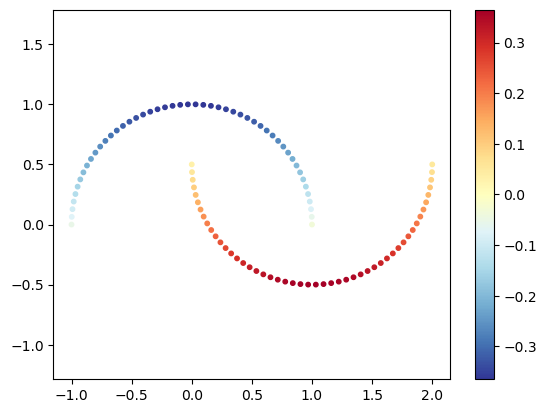

In [461]:
ncomp = 2
amplitudes, Λ, V, K = kernel_PCA(X,kernel,ncomp)

scatter(X[1,:],X[2,:],10,amplitudes[1,:])
axis("equal")
colorbar();

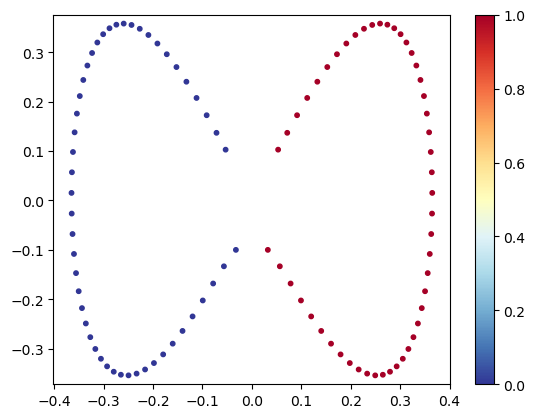

In [462]:
scatter(amplitudes[1,:],amplitudes[2,:],10,y)
axis("equal")
colorbar();

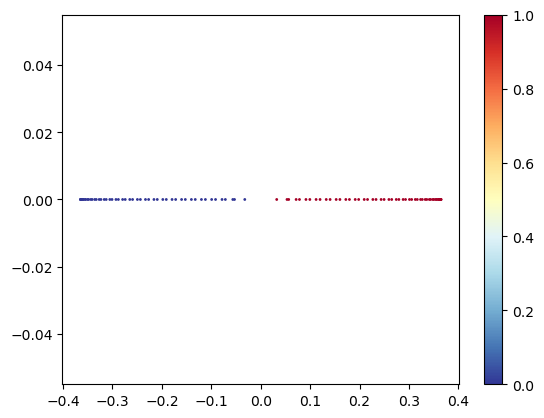

In [463]:
scatter(amplitudes[1,:],zeros(N),1,y); colorbar();

### Klasyczne PCA dla danych półksiężyca

In [445]:
X_pca = my_pca(X, 2, maxiter=250)

2×100 Matrix{Float64}:
 -0.875563  -0.168199  1.39805   0.125323   …   0.965047  -0.930153  1.98074
 -0.483104  -0.985753  0.787091  0.0306477     -0.262077  -0.367173  0.314044

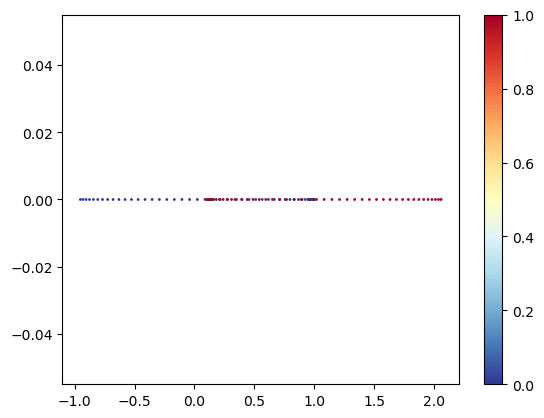

In [449]:
scatter(X_pca[1,:],zeros(N),1,y); colorbar();